In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat, savemat
from scipy.stats import gaussian_kde
import chaospy as cp
import numpoly
import seaborn as sns

In [2]:
### GENERATE MONTE CARLO INPUTS FOR E_hard & E_soft ###
np.random.seed(1)

E_s_mean = 200e6
E_s_range = 100e6
E_h_mean = 200e9
E_h_range = 100e9

rho_s_mean = 1e3
rho_s_range = 5e2
rho_h_mean = 8e3
rho_h_range = 4e3

pr_h_mean = 0.25
pr_h_range = 0.25
pr_s_mean = 0.25
pr_s_range = 0.25

E_soft_dist = cp.Uniform(E_s_mean-E_s_range, E_s_mean+E_s_range)
E_hard_dist = cp.Uniform(E_h_mean-E_h_range, E_h_mean+E_h_range)
rho_soft_dist = cp.Uniform(rho_s_mean-rho_s_range, rho_s_mean+rho_s_range)
rho_hard_dist = cp.Uniform(rho_h_mean-rho_h_range, rho_h_mean+rho_h_range)
pr_soft_dist = cp.Uniform(pr_s_mean-pr_s_range, pr_s_mean+pr_s_range)
pr_hard_dist = cp.Uniform(pr_h_mean-pr_h_range, pr_h_mean+pr_h_range)
joint_dist = cp.J(E_soft_dist, E_hard_dist, rho_soft_dist, rho_hard_dist, pr_soft_dist, pr_hard_dist)

In [3]:
degrees = [2, 3, 4, 5]
quadrature_surrogates = {}
quadrature_nodes = {}
quadrature_weights = {}
for d in degrees:
    nodes, weights = cp.generate_quadrature(d, joint_dist, rule='G')
    #nodes, weights = cp.quadrature.legendre(order=d, lower=E_soft_dist.lower, upper=E_soft_dist.upper)
    quadrature_nodes[d] = nodes
    quadrature_weights[d] = weights

#quadrature_nodes

for qd in quadrature_nodes:
    savemat('joint_dist_pd_'+str(qd)+'.mat',{'pd_'+str(qd)+'_inputs':quadrature_nodes[qd]})

In [4]:
E_soft_sample_sets = {}
E_hard_sample_sets = {}
rho_soft_sample_sets = {}
rho_hard_sample_sets = {}
pr_soft_sample_sets = {}
pr_hard_sample_sets = {}
bg_size_sample_sets = {}
bg_top_sample_sets = {}
bg_bottom_sample_sets = {}

for d in degrees:
    folder_name = 'quad_6i_pd'+str(d)
    file_suffix = '_q_pd'+str(d)+'_uniform_'+str((d+1)**6)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)
    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_sample_sets[d] = E_soft_file['E_soft'][:]
    E_hard_sample_sets[d] = E_hard_file['E_hard'][:]
    rho_soft_sample_sets[d] = rho_soft_file['rho_soft'][:]
    rho_hard_sample_sets[d] = rho_hard_file['rho_hard'][:]
    pr_soft_sample_sets[d] = pr_soft_file['poisson_soft'][:]
    pr_hard_sample_sets[d] = pr_hard_file['poisson_hard'][:]
    bg_size_sample_sets[d] = bg_size_file['bg_size'][:]
    bg_top_sample_sets[d] = bg_top_file['bg_top'][:]
    bg_bottom_sample_sets[d] = bg_bottom_file['bg_bottom'][:]

#bg_size_sample_sets

In [62]:
E_soft_MC_sets = {}
E_hard_MC_sets = {}
rho_soft_MC_sets = {}
rho_hard_MC_sets = {}
pr_soft_MC_sets = {}
pr_hard_MC_sets = {}
bg_size_MC_sets = {}
bg_top_MC_sets = {}
bg_bottom_MC_sets = {}

set_N = [100, 1000, 10000]
for N in set_N:
    folder_name = 'mc_'+str(N)
    file_suffix = '_mc_uniform_'+str(N)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)
    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_MC_sets[N] = E_soft_file['E_soft'][:]
    E_hard_MC_sets[N] = E_hard_file['E_hard'][:]
    rho_soft_MC_sets[N] = rho_soft_file['rho_soft'][:]
    rho_hard_MC_sets[N] = rho_hard_file['rho_hard'][:]
    pr_soft_MC_sets[N] = pr_soft_file['poisson_soft'][:]
    pr_hard_MC_sets[N] = pr_hard_file['poisson_hard'][:]
    bg_size_MC_sets[N] = bg_size_file['bg_size'][:]
    bg_top_MC_sets[N] = bg_top_file['bg_top'][:]
    bg_bottom_MC_sets[N] = bg_bottom_file['bg_bottom'][:]

In [121]:
print(type(bg_size_sample_sets))
print(len(bg_size_sample_sets[2]))

print(type(bg_size_MC_sets))
print(len(bg_size_MC_sets[10000]))
# fig = plt.figure()
# plt.scatter(E_soft_sample_sets[2], bg_size_sample_sets[2])
# plt.title('Black Box Model Evaluations on 2th order quadrature samples')
# plt.xlabel('E_soft')
# plt.ylabel('bg_size')

<class 'dict'>
729
<class 'dict'>
10000


In [98]:
### FIT SURROGATE MODELS - QUADRATURE RULE ###
q_surrogates = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_size_sample_sets[degree]
    )
    q_surrogates[degree] = polynomial_approximation

In [99]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 1000
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs = {}
surrogate_kdes = {}
surrogate_pdf = {}
for degree in degrees:
    surrogate_model = q_surrogates[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes[degree] = gaussian_kde(surrogate_outputs[degree])
    surrogate_pdf[degree] = surrogate_kdes[degree](np.linspace(np.min(surrogate_outputs[degree]), np.max(surrogate_outputs[degree]), 1000))

(6, 1000)


In [118]:
### PLOT SURROGATE PDF CONVERGENCE ###
# plt.figure()
# #plt.hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)
# for d in degrees:
#     plot_label = 'PD='+str(d)
#     plt.scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
# plt.xlabel("Model Output (Angular frequency)")
# plt.ylabel("Probability Density")
# title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, Orders 2 to 5'
# plt.title(title_str)
# plt.legend(loc='best')

Compare to Monte Carlo

In [101]:
### GENERATE MONTE CARLO INPUT SAMPLES ###
N_MC2 = 100
N_MC3 = 1000
N_MC4 = 10000

joint_samples_MC2 = joint_dist.sample(N_MC2)
joint_samples_MC3 = joint_dist.sample(N_MC3)
joint_samples_MC4 = joint_dist.sample(N_MC4)

savemat('joint_dist_mc_'+str(N_MC2)+'.mat',{'mc_'+str(N_MC2)+'_inputs':joint_samples_MC2})
savemat('joint_dist_mc_'+str(N_MC3)+'.mat',{'mc_'+str(N_MC3)+'_inputs':joint_samples_MC3})
savemat('joint_dist_mc_'+str(N_MC4)+'.mat',{'mc_'+str(N_MC4)+'_inputs':joint_samples_MC4})

In [115]:
# plt.figure()
# plt.hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
# for d in degrees:
#     plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
#     plt.scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
# plt.xlabel("Model Output (Angular frequency)")
# plt.ylabel("Probability Density")
# title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, \nOrders 2 to 5 Compared to Histogram of 100 MC Samples'
# plt.title(title_str)
# plt.legend(loc='best')

In [116]:
# plt.figure()
# plt.hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
# for d in degrees:
#     plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
#     plt.scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
# plt.xlabel("Model Output (Angular frequency)")
# plt.ylabel("Probability Density")
# title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, \nOrders 2 to 5 Compared to Histogram of 1000 MC Samples'
# plt.title(title_str)
# plt.legend(loc='best')

In [117]:
# plt.figure()
# plt.hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)
# for d in degrees:
#     plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
#     plt.scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
# plt.xlabel("Model Output (Angular frequency)")
# plt.ylabel("Probability Density")
# title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, \nOrders 2 to 5 Compared to Histogram of 10000 MC Samples'
# plt.title(title_str)
# plt.legend(loc='best')

Text(0.5, 0.98, 'Bandcap Size Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

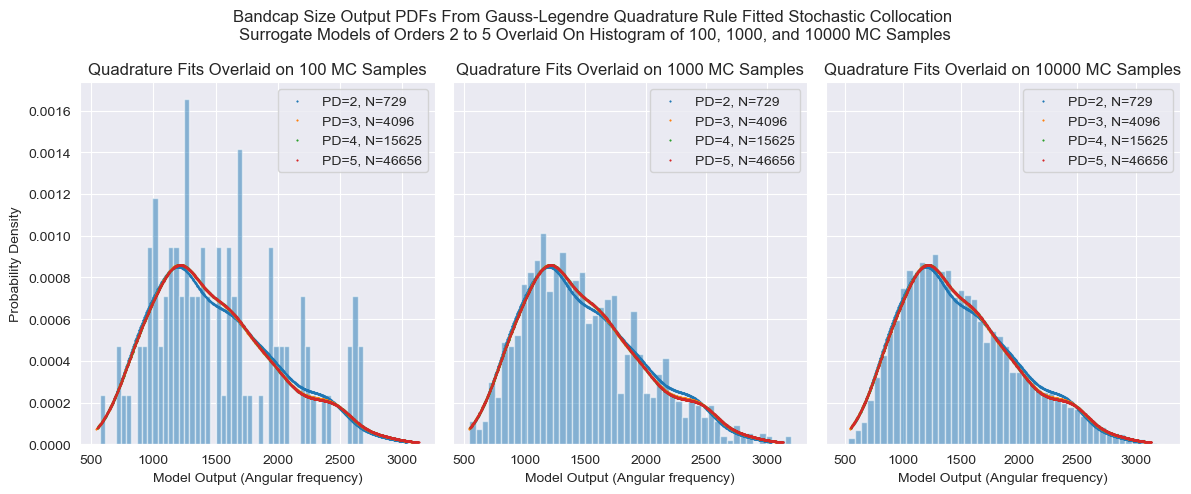

In [106]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Angular frequency)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Angular frequency)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Angular frequency)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandcap Size Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Quadrature fits on bandgap bottom and top

Stochastic Collocation with Regression on MC Samples

In [63]:
MC_inputs = {}
for n in set_N:
    MC_inputs[n] = np.vstack((
        E_soft_MC_sets[n],
        E_hard_MC_sets[n],
        rho_soft_MC_sets[n],
        rho_hard_MC_sets[n],
        pr_soft_MC_sets[n],
        pr_hard_MC_sets[n]
    ))

In [111]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    # print(fit_input.shape)
    # print(bg_size_MC_sets[100].shape)
    polynomial_approximation = cp.fit_regression(
        polynomials=polynomial_basis,
        abscissas=MC_inputs[1000],
        #abscissas=quadrature_nodes[degree],
        evals=bg_size_MC_sets[1000],
        #evals=bg_size_sample_sets[degree]
    )
    r_surrogates[degree] = polynomial_approximation

In [112]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 1000
joint_test_mc = joint_dist.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for degree in degrees:
    mc_surrogate_model = r_surrogates[degree]
    #print(type(mc_surrogate_model))
    #print(mc_surrogate_model)
    mc_surrogate_outputs[degree] = mc_surrogate_model(
        q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
        q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
        q4=joint_test_mc[4,:], q5=joint_test_mc[5,:])
    #print(mc_surrogate_outputs[degree])
    mc_surrogate_kdes[degree] = gaussian_kde(mc_surrogate_outputs[degree])
    mc_surrogate_pdf[degree] = mc_surrogate_kdes[degree](np.linspace(np.min(mc_surrogate_outputs[degree]), np.max(mc_surrogate_outputs[degree]), 1000))

Text(0.5, 0.98, 'Bandcap Size Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

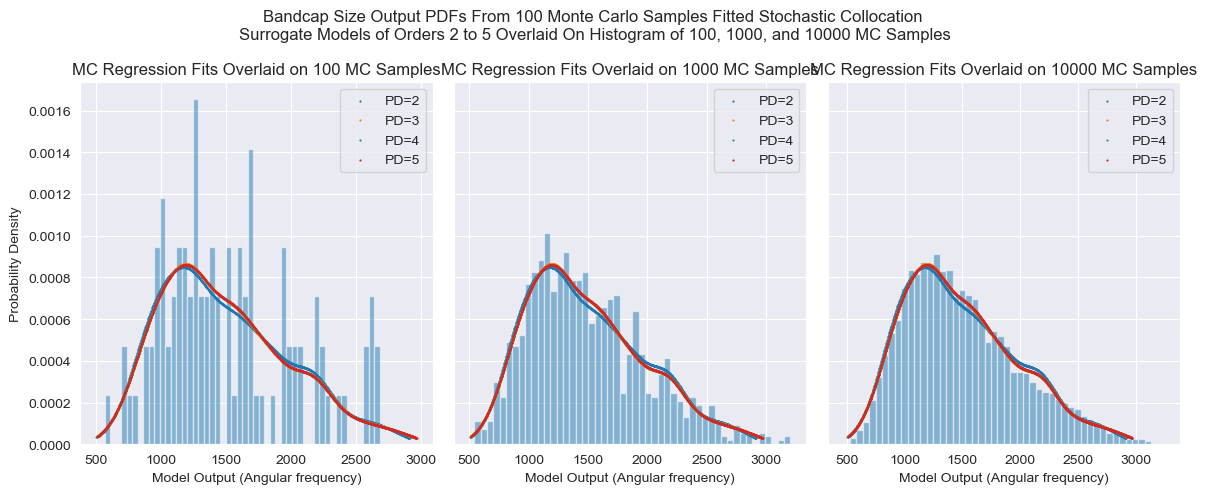

In [113]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in degrees:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Angular frequency)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Angular frequency)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Angular frequency)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Fits Overlaid on 10000 MC Samples')

title_str = 'Bandcap Size Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)